In [1]:
# %pip install numpy pandas matplotlib seaborn nltk

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

import os



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/oscarpinon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Stonks, HODL, to the moon, and wallstreetbets

2020 has shown the power of social media and it's ability to move financial markets.

Whether this power is at best a way of increasing market efficeincy by improving the flow of information to a wider audience of investors, or at worst a way for malicious market participants to pump and dump stock prices at the expense of the less informed, or maybe it is an annomoly, with people stuck at home during the pandemic with a lot of time on their hands and maybe a few extra dollars saved to play with.

### Technical Indicators ~ Sentiment

Technical Indicators are a branch of financial analysis based on the idea that the share price and it's movements encapsulates a huge amount of information, and by tracking various metrics a practitioner will be able to derive a view of the market or a stock solely on these technical indicators. There are many indicators widely used, and resources available online to dive into the detail of each indicator and what it represents.

Here I use some of the most common technical indicators as a way to measure market sentiment and test whether the implied market sentiment is related to the sentiment we find in twitter universe.

I use price data which was sourced from https://www.kaggle.com/omermetinn/values-of-top-nasdaq-copanies-from-2010-to-2020

#### Moving Averages

MA's are intended to capture the price momentum of a stock by identifying trend direction and determining support and resistance levels. Here I use some of the most common horizons 10 day, 20 day, 50 day and 100 day. Analysts monitor these to determine trends, and maybe crucially these can be used to predict when trends may change direction.

#### Relative Strength Index

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.

#### MACD

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. Traders may buy the security when the MACD crosses above its signal line and sell the security when the MACD crosses below the signal line.

Check out investopeida.com for further detail.

In [2]:
# import prices

prices=pd.read_csv('datasets/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv')
# format date
prices['day_date'] = pd.to_datetime(prices['day_date'], format="%Y-%m-%d").dt.date.astype('datetime64[ns]')
prices=prices.sort_values(by=['day_date']).reset_index()
# rename date column for consistency
prices=prices.rename(columns={"day_date": "date"})

def create_indicators(data):
    
    prices = data.sort_values(by=['date']).reset_index()

    # create simple moving average
    n=[10,20,50,100]
    for i in n:
        prices.loc[:,(str("MA"+str(i)))]=prices['close_value'].rolling(i).mean()    

    # Calculate MACD  
    day26=prices['close_value'].ewm(span=26, adjust=False).mean()
    day12=prices['close_value'].ewm(span=12, adjust=False).mean()
    prices.loc[:,('macd')]=day12-day26 
    prices.loc[:,('signal')]=prices['macd'].ewm(span=9, adjust=False).mean()

    # Calculate RSI 
    up = np.log(prices.close_value).diff(1)
    down = np.log(prices.close_value).diff(1)

    up[up<0]=0
    down[down>0]=0

    # Calculate the EWMA
    roll_up = up.ewm(span=14).mean()
    roll_down = down.abs().ewm(span=14).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up / roll_down
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    prices.loc[:,('rsi')]=RSI1

    return prices

# create dict, by ticker
d = dict(tuple(prices.groupby('ticker_symbol')))
d = {k:create_indicators(v) for k, v in d.items()}

def subset_prices(d,ticker,start,end):
    x=d[ticker]
    x=x[((x.date>=start)&(x.date<=end))]
    return x

### Tweet Data Preperation

Estimating the sentiment of each tweet

It would be interesting to investigate whether stock sentiment can be quantified using tweets related to a company.

This large dataset of tweets doesn't come with a sentiment tag so I will use NLTK's built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

VADER relies on a dictionary that maps words and other numerous lexical features common to sentiment expression in microblogs.

These features include:

A full list of Western-style emoticons ( for example - :D and :P )
Sentiment-related acronyms ( for example - LOL and ROFL )
Commonly used slang with sentiment value ( for example - Nah and meh )
Manually creating a thorough sentiment dictionary is a labour-intensive and sometimes error-prone process.
Thus it is no wonder that many NLP researchers rely so heavily on existing dictionaries as primary resources.

The below code returns the 'compound' score for each tweet,this score ranges from -1 (most negative) to +1 ( most positive).

To create a categorical variable I apply the following heuristic:

Neg = compound score < -0.6
Pos = compound score > +1.4
Neutral = -0.6 < compound score < +1.4
Having tested VADER against a selection of hypothetical tweets, it appeared that the standard vocabulary wasn't sufficent for this task (see the below examples), but we can augment this vocabulary used by the sentiment analyser with some terminology related to stock market sentiment

e.g. "Buy","Hold","Bull","Bear","Bubble"

In [3]:
# import tweets
tweets=pd.read_csv('datasets/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')
company_tweet=pd.read_csv('datasets/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv')

tweets=tweets.merge(company_tweet,how='left',on='tweet_id')
# format dates
tweets['date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.date
tweets.date=pd.to_datetime( tweets.date,errors='coerce')
tweets['time'] = pd.to_datetime(tweets['post_date'], unit='s').dt.time

In [4]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(tweets,ticker='TSLA',start='2017-01-01',end='2017-02-01'):
    #sbuset
    df=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]
    # applt the SentimentIntensityAnalyzer
    df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
    # create label
    #bins= pd.interval_range(start=-1, freq=3, end=1)
    df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
    
    df=df.loc[:,["date","score","label","tweet_id","body"]]
    return df

print('tesla misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('tesla misses earnings, analyst suggest downgrade , sell now ')

tesla misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}

In [5]:
# augment vocab

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)


print('tesla misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('tesla misses earnings, analyst suggest downgrade , sell now ')

tesla misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.7845}

I create some reusable funcitions for plotting (should I do some more analysis)

In [6]:
## Sentiment from Price
def price_plot_ma(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr

    n = df.shape[0] # number of dates
    if ax is None:
        ax = plt.gca()
        
    # format data for seaborn
    df=df.melt(id_vars='date',var_name='var', value_name='vals')
    df=df[df['var'].isin(['close_value','MA10','MA20','MA50','MA100'])]
    df['vals']=df['vals'].astype(float)
    df.index=df.date.dt.date
    df.date=df.date.dt.date
    # set axis formats / Set the locator
    if ax is None:
        ax = plt.gca()
        
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    

        
    ax.set_ylabel('Close Price')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.lineplot(data=df, x='date', y='vals',hue='var',palette='cool_r',ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=True)
    return ax


In [7]:
def price_plot_vol(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    
    n=df.shape[0]
    
    df.index=df.date.dt.date
    if ax is None:
        ax = plt.gca()
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    
    ax.set_ylabel('Traded Volume (million)')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x/1000000), ',')))
    sns.lineplot(data=df, x='date', y='volume',palette='cool_r',ax=ax)

    return ax

In [8]:
def sentiment_barplot(df,ax=None, **plt_kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    
    df=df.groupby(['date','label'])['tweet_id'].agg('count').reset_index(name="count")
    
    n=len(df.date.unique())
    
    # format the data and make proportion
    df=df.pivot(index='date',columns='label',values='count')
    df=pd.DataFrame(df.to_records()).reset_index()
    df.loc[:,"total"]=df.loc[:,['bad','neutral','good']].sum(axis=1)
    df.loc[:,['bad','neutral','good']]=df.loc[:,['bad','neutral','good']].div(df.total,axis=0)
    df.loc[:,"total"]=df.loc[:,['bad','neutral','good']].sum(axis=1)
    df=df.drop(['total'], axis=1)
   
    df.index=df.date.dt.date
    if ax is None:
        ax = plt.gca()
    colors=['crimson','lightgrey','mediumseagreen']
    df.loc[:,['bad','neutral', 'good']].plot.bar(stacked=True, color=colors, width=1.0,alpha=0.5,ax=ax)
    
   
    # set axis formats / Set the locato
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
         
    
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    
    ax.grid(True, which='major',axis='both')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True, shadow=True)
    return ax

In [9]:
def sentiment_tweet_vol(df,ax=None,**kwargs):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.ticker as tkr
    df=df.groupby(['date'])['label'].agg('count').reset_index(name="count")
    df.index=df.date.dt.date
    n=len(df.date.unique())
    
    if ax is None:
        ax = plt.gca()
    # set axis formats / Set the locator
    
    major_locator = mdates.MonthLocator()  
    major_fmt = mdates.DateFormatter('%b')
    minor_locator = mdates.DayLocator(interval=1) 
    minor_fmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.grid(True, which='major',axis='both')
    
    if n > 750:
        major_locator = mdates.YearLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%Y')
        minor_locator =  mdates.MonthLocator()
        minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if((n > 250 ) & (n< 750 )):
        major_locator = mdates.MonthLocator()   # every year and quarter
        major_fmt = mdates.DateFormatter('%b-%Y')
        #minor_locator =  mdates.MonthLocator()
        #minor_fmt = mdates.DateFormatter('%b')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        #ax.xaxis.set_minor_locator(minor_locator)
        ax.grid(True, which='major',axis='both')
        
    if ((n > 90 ) & (n< 250 )):
        major_locator = mdates.MonthLocator()   # every  month
        major_fmt = mdates.DateFormatter('%b-%y')
        minor_locator = tkr.AutoMinorLocator(4)
        minor_fmt = mdates.DateFormatter('%d-%m')
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_fmt)
        ax.xaxis.set_minor_locator(minor_locator)
        #ax.xaxis.set_minor_formatter(minor_fmt)
        ax.grid(True, which='major',axis='both')
        
    ax.set_ylabel('Tweet Volume')
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.lineplot(data=df, x='date', y='count',palette='cool_r',ax=ax)
    
    return ax

In [10]:
def corr_plot(sp,tw):
    
    x=tw.groupby(['date','label']).agg({"score":['count','mean']}).unstack('label') 
    sp=sp.reset_index(drop=True)
    # format the data and make proportion
    x=pd.DataFrame(x.to_records())
    # format columns names
    x.columns=['date','count_bad','count_neutral','count_good','score_mean_bad','score_mean_neutral','score_mean_good']
    x.loc[:,'tweet_volume']=x.loc[:,['count_bad','count_neutral','count_good']].sum(axis=1)
    x.loc[:,'count_ratio_gb']=x.count_good/x.count_bad # create a ratio good:bad
    # join price
    x=x.merge(sp.loc[:,['date','MA10', 'MA20', 'MA50','MA100', 'macd', 'rsi','volume']],how='left',left_on='date',right_on='date')

    corr = x.corr()
    # Getting the Upper Triangle of the co-relation matrix
    matrix = np.triu(corr)
    ax = sns.heatmap(
        round(corr,3),
        vmin=-1, vmax=1, center=0,
        cmap="YlGnBu",annot=True,annot_kws={"fontsize":8}, fmt=".2",
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    return ax

## Telsa - As an example

Taking Tesla as an example, we'll first examine the price plot to examine an interval where we see an interesting pattern in the stock price, and then drill down to examine any relationship between market and twitter sentiment. 

It looks like the period from 2018 - 2020 could be an interesting case study, from the chart we see sentiment go from a downward price trend to a very strong upward trend, where the TSLA share price has increased massively right up to the COVID-19 panic.

<Axes: xlabel='Date', ylabel='Close Price'>

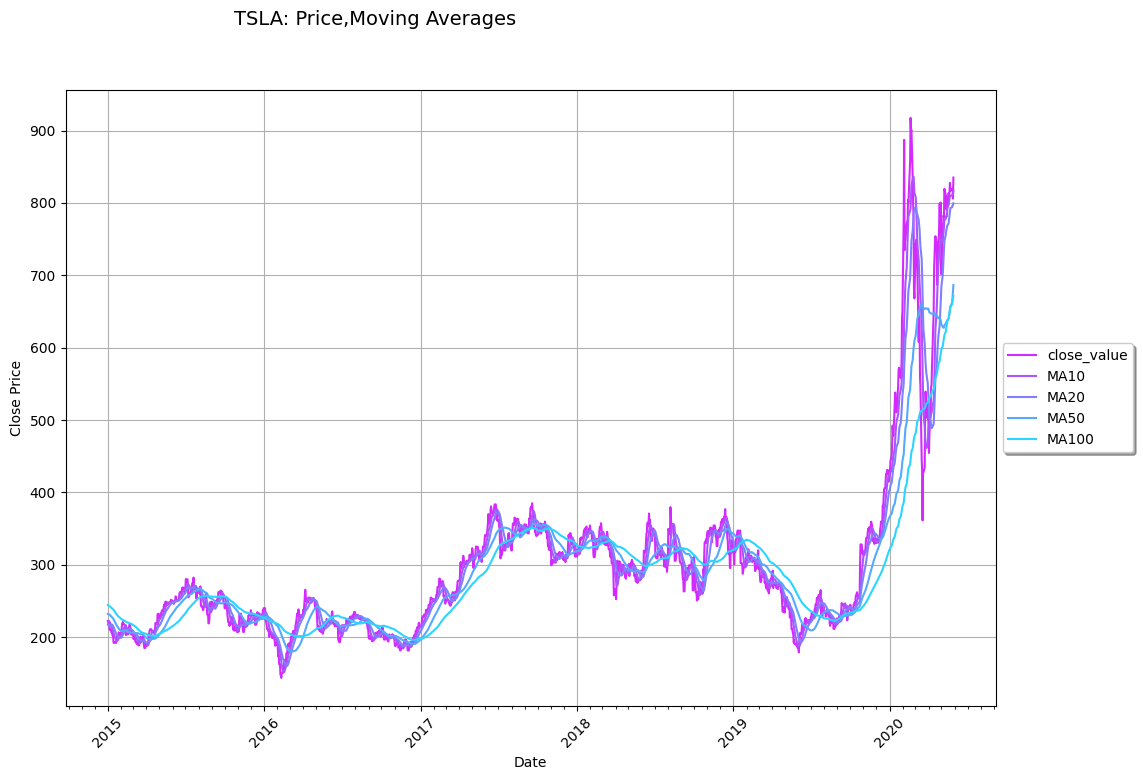

In [11]:
start='2015-01-01'
end='2020-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/4097567334.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/4097567334.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
/var/folders/j3/5r_2596d4yj98yqp9jzcqy

<Axes: xlabel='Date', ylabel='Sentiment'>

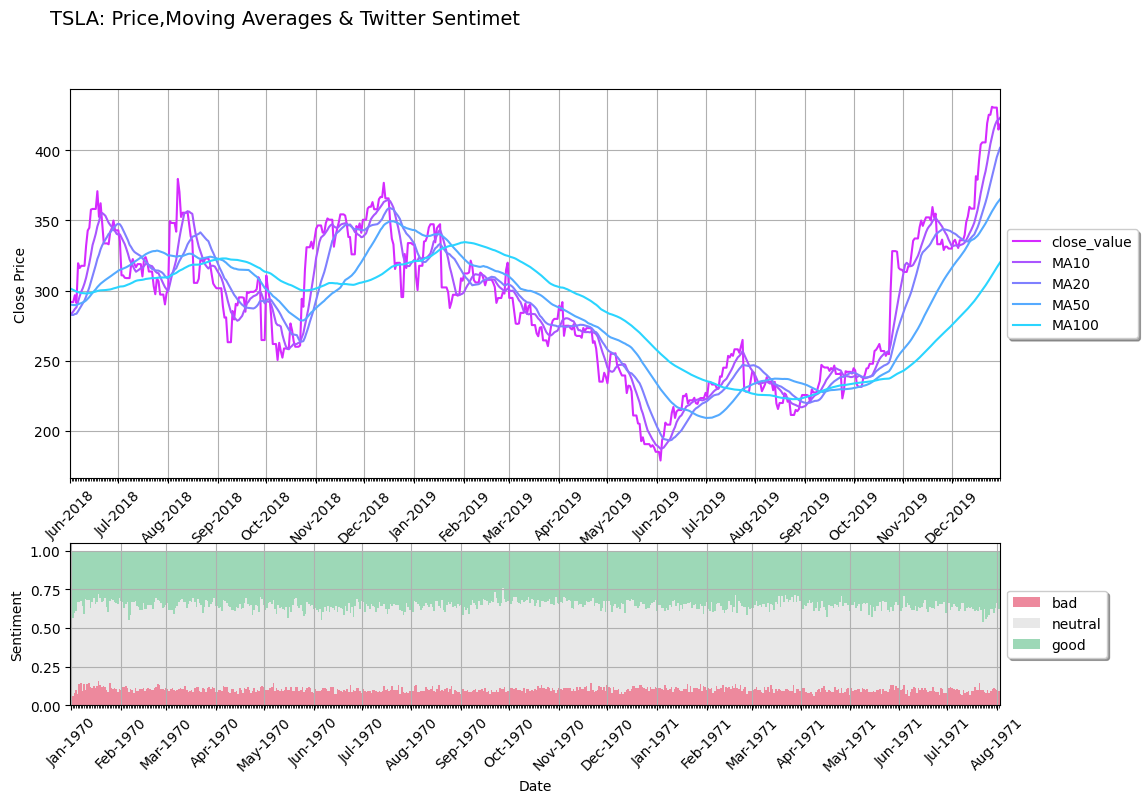

In [12]:
start='2018-06-01'
end='2019-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)

Having categorised each tweet as good, neutral or bad, I plot the daily propotion alongside the price chart to see if the change in trend is reflected in both.

However, it appears that across this time period, even though market sentiment was quite up and down, positive twitter sentiment persisted. Perhaps I need to account for the trend in the broader market (S&P 500), as although the Tesla stock does trend down it may have performed better than the market and this might explain the persisiting twitter sentiment

I also examine the relationship between 'tweet volume' and 'trade volume' to see if there is any correlatio

/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/3854662533.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='date', y='volume',palette='cool_r',ax=ax)
/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/3244989882.py:58: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x='date', y='count',palette='cool_r',ax=ax)


<Axes: xlabel='Date', ylabel='Tweet Volume'>

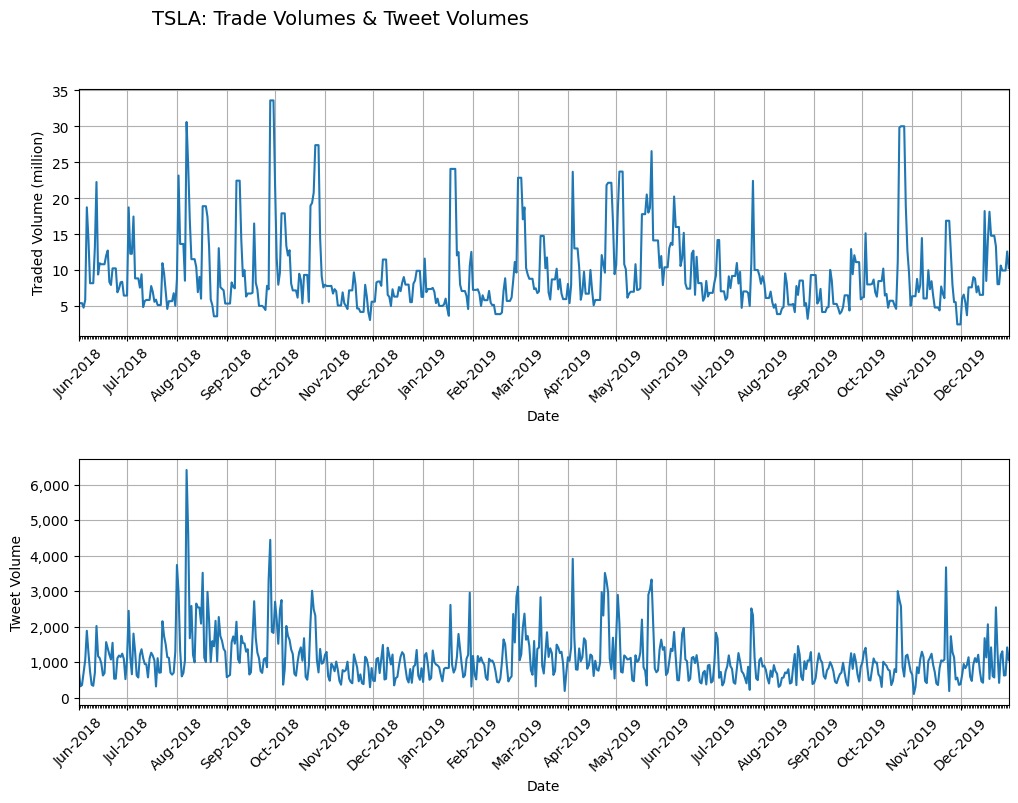

In [13]:
gridsize = (2, 2) # 2 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Trade Volumes & Tweet Volumes",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2.set_xlim(min(tw.date),max(tw.date))
price_plot_vol(ax=ax1, df=sp)
sentiment_tweet_vol(ax=ax2,df=tw)

Visually there does appear to be a relationship between the volume metrics, but it is difficult to say which is the driving force, are people tweeting because the market is moving, or vice versa?

For example, you see similar spikes in Aug-2018 and Oct-2018. The pattern of traded volume seems to be monthly, whereas twitter volume seems to follow a pattern of spikes every few months, broadly in line with quarterly earning announcements.

I generate a simple correlation plot to measure the relationship of the variables, from the plots above I would expect some positive correlation between tweet and trade volume, and not expect to see a very string relationship between twitter sentiment and my technical indicators of sentiment (MA,MACD,RSI)

/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/2514249909.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x=tw.groupby(['date','label']).agg({"score":['count','mean']}).unstack('label')


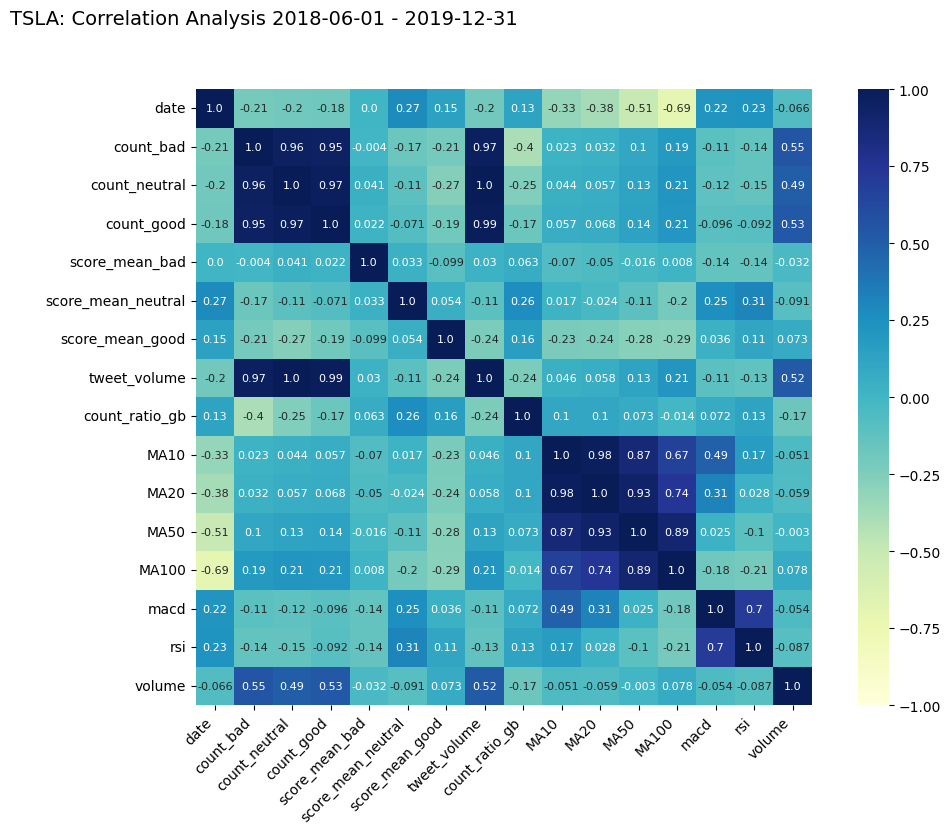

In [14]:
fig,ax = plt.subplots(figsize=(12, 8))
fig.suptitle(ticker + ": Correlation Analysis "+ start+ " - " + end,fontsize=14,horizontalalignment='right', verticalalignment='top')
ax=corr_plot(sp,tw)

Volume & Tweet volume do exhibit fairly strong correlation
The average score (strength of sentiment) does have the expected behavipur w.r.t to the MA,MACD and RSI sentiment measures.

Positive twitter sentiment is reflected in the positive correlation (very weak) with MACD and RSI
Similarily for negative tweet sentiment, although again this is a weak effect.

### What are the best and worse tweets?

Having applied the sentiment analyser, it would be interesting to see what the best and worst tweets were, and how closely the relate to the goal here, linking twitter sentiment to the stock market.

The following are the top 10 and bottom 10 tweets based on the NLTK's VADER, and we can certainly see that the sentiment of this falls into "good' and "bad categories, but they aren't always specific to Tesla stock, and there is a lot of noise related to people's customer experience of tesla ( in particular the negative sentiment tweets below).


In [15]:
for i in tw.sort_values('score',ascending=False).body.head(10):
    print(i, sep="\n")

Today's Highlight from Pre-Market Notes 5/17/2019$OTLK LONG $1.19-->$2.77 #SWING$AMAT LONG $42-->$44$NVDA LONG $158-->$163$BA LONG $352-->$360$BYND LONG $90-->$96$PINS LONG $26-->$28$BOOT LONG $27-->$30$TSLA LONG $217-->$220$BIDU LONG $130-->$134
Today's Highlight from Pre-Market Notes 5/21/2019$MNK LONG $8.50-->10$BA SHORT $362-->355$ARRY LONG $20-->25$TSLA LONG $197-->203$QRVO LONG $62-->68$LITE LONG $46-->49$TTD LONG $190-->198$LITE LONG $200-->207$NVDA LONG $152.75-->156$ARWR LONG $21
I've been rolling options premiums for years on $TSLA. You guys have kept the theta so high in what should be a sleepy boring stock. But yeah, I would call that long term since its IPO. Buy and hold is not the only way to play long term growth.
hehe Beavis: $TSLA is waiting for boring and boneheaded questions of those analysts tonight; hehe; but watch our for real cool stuff happening than. Gonna be so great, greatest Q2 call ever, amazing linguistic talents will unfold, new words created like from go

In [16]:
for i in tw.sort_values('score',ascending=False).body.tail(10):
        print(i)

Is there something just filthy, rotten, stinking, nasty, corrupt, vile, disgusting, polluted, & tainted about Chicago politics? Well, sure, but it is any more filthy, rotten, stinking, nasty, corrupt, vile, disgusting, polluted, or tainted than $TSLA corporate governance? Nope.
Corey STFU. You’re a f..king short, no consideration for anything but your dirty pockets! I hope one day you will get the hell you deserve! You are a selfish shit moron, your actions are a disgrace to the people that will suffer from #ClimateWarming and as such it’s criminal!
#Long$TSLA 345.73Rocketing through secondary resistance 321-324. Challenged upper-head resistance 341-346. Short squeeze in progress. Rocketing through primary resistance 289-292 in death cross pattern. Short squeeze in progress. Nr Term Obj 406, Stop Loss 298. Volatile.
A spike in an otherwise continuing downward trans production hell, financial hell, customer service hell and lastly valuation hell $tsla oh and Sell sell sell $tsla
Today's

### AAPL - As an example

Taking Tesla as an example, we'll first examine the price plot to examine an interval where we see an interesting pattern in the stock price, and then drill down to examine any relationship between market and twitter sentiment.

It looks like the period from 2018 - 2020 could be an interesting case study, from the chart we see sentiment go from a downward price trend to a very strong upward trend, where the TSLA share price has increased massively right up to the COVID-19 panic.

<Axes: xlabel='Date', ylabel='Close Price'>

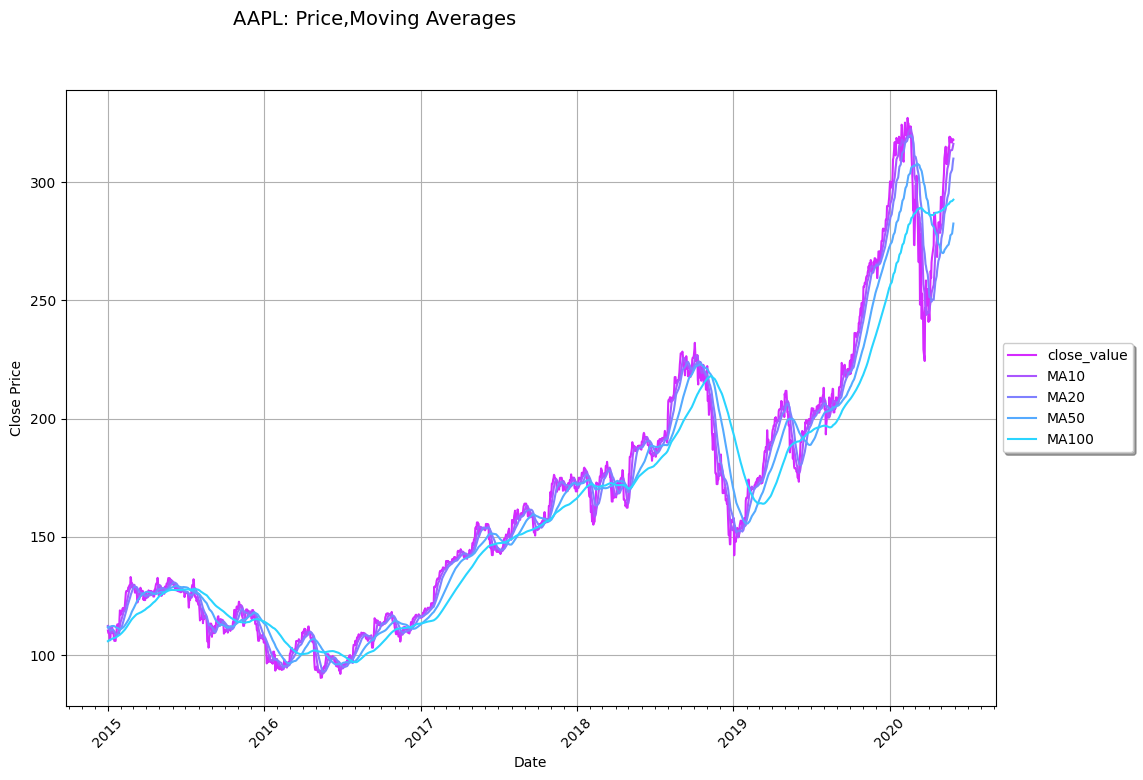

In [17]:
start='2015-01-01'
end='2020-12-31'
ticker='AAPL'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/4097567334.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/4097567334.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
/var/folders/j3/5r_2596d4yj98yqp9jzcqy

<Axes: xlabel='Date', ylabel='Tweet Volume'>

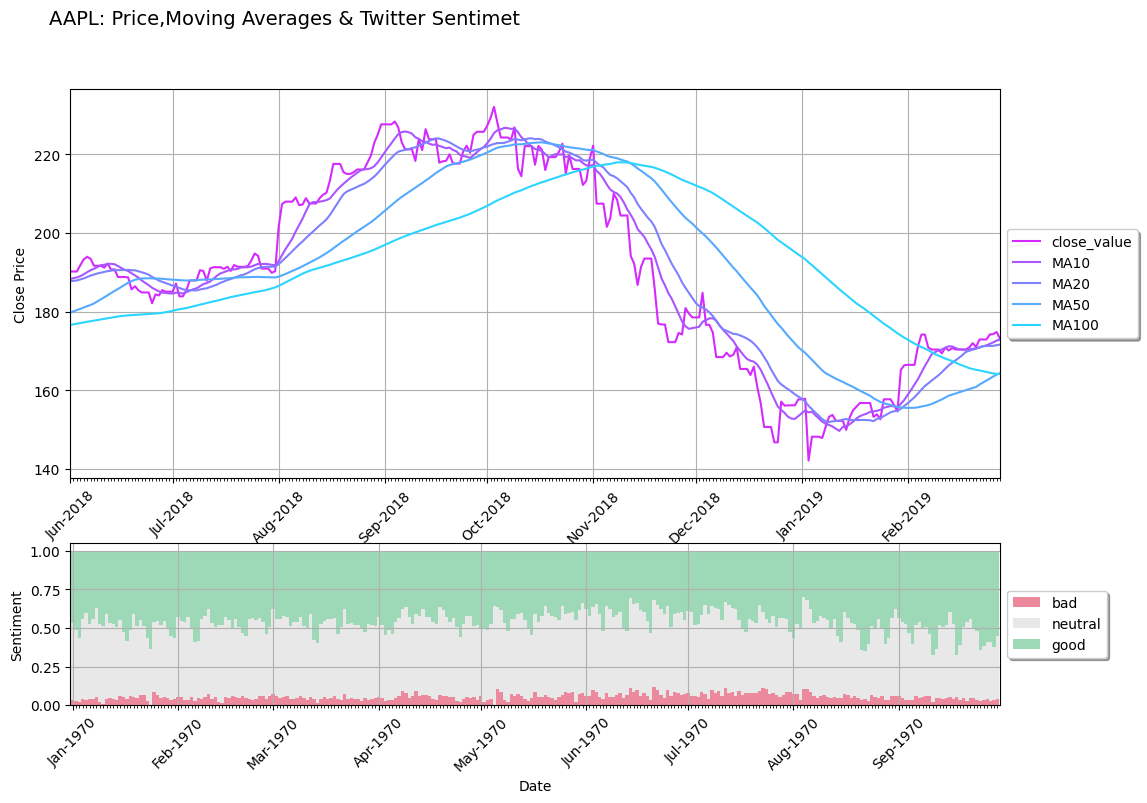

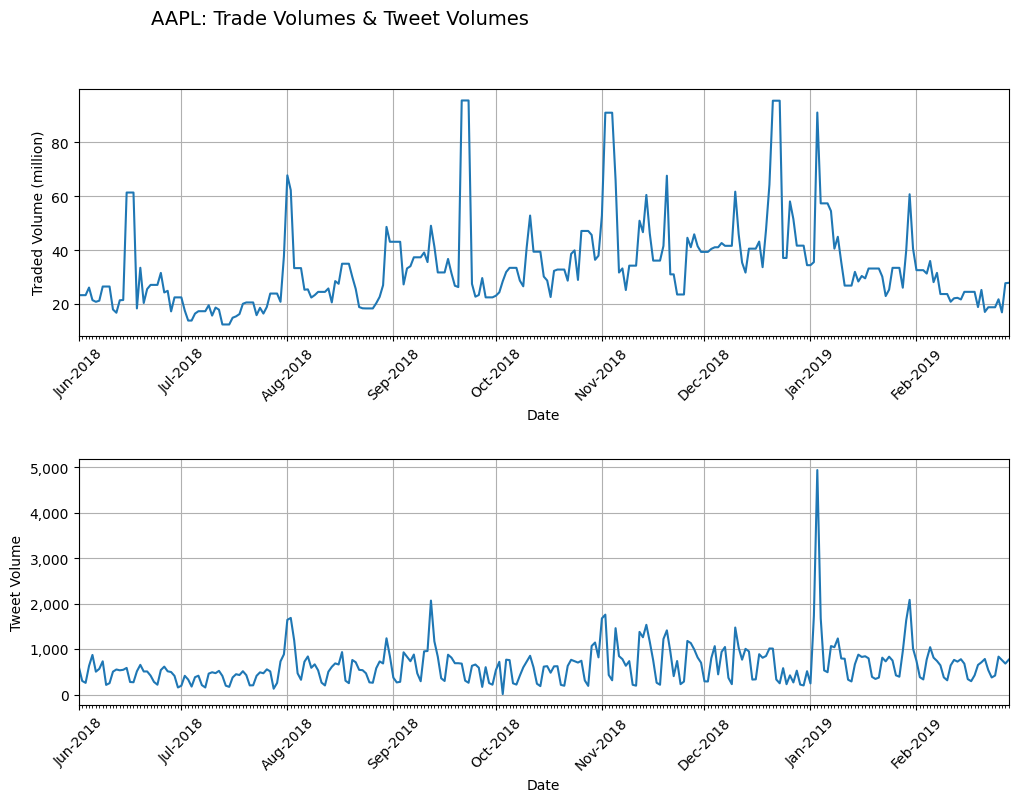

In [18]:
start='2018-06-01'
end='2019-02-28'
ticker='AAPL'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)

gridsize = (2, 2) # 2 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Trade Volumes & Tweet Volumes",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2.set_xlim(min(tw.date),max(tw.date))
price_plot_vol(ax=ax1, df=sp)
sentiment_tweet_vol(ax=ax2,df=tw)

### There is always more bulls than bears?

Again, twitter sentiment has a strong postivie bias (almost 50% positive) , which doesn't tie in to the market moves. 

Also the top/bottom tweets look to caputure the correct sentiment, but I suspect that there is a lot of 'noise' being captured that is unrelated to the financial performance of Apple.

In [19]:
for i in tw.sort_values('score',ascending=False).body.head(10):
    print(i, sep="\n")

$FAANG - $FB $AMZN $AAPL $NFLX $GOOGL - A daily 3 month chart. #Facebook in main #bull trend + #short move, #Amazon in bull trend with long tail down #Apple in main bull trend #Netflix bull in long tail down #Alphabet bull trend with triple bottom breakout
07-27: the top scored Health Care company is CELLDEX THERAPEUTICS IN$CLDX scored at 63.22Key words: GROWTH, EXPECTING, PRICE, DREAM, GOOD, STRONG, BUYING, DOWN, MARKET, BUY, SELLING, TRADING, SUCCESS, DELISTING, BETTER, BEST, SERIOUS..#startup $BTC $AMD $AAPL $NFLX #crypto
buy $FB buy $AAPL buy buy buy as the FAANG man says. So people buy buy buy.  Can only imagine what pct these make up in this market
Depends on your time horizon, of course, but you don’t need a very long time horizon 2 benefit from buying $AAPL. This is such a great company w/so many great products, a vast & loyal customer base, & tremendous potential 4 news products, services & growth — U have 2B a buyer.
Yes I know. You made all that money by that $2 stock price 

In [20]:
for i in tw.sort_values('score',ascending=False).body.tail(10):
    print(i, sep="\n")

$CGC tried long cuz of wicks and VWAP bounce. horrible entry$MDT short on open. Huge gap up with no pullback on daily so many will be taking profits. short rejection of VWAP but there was weird buying volumemissed alot of trades: $AAPL short $TOL short $CRON short $CGC short
loser day $AMD failed to hold above VWAP so short under it$AAPL short VWAP reject$FB got the opening short. tried long as it held higher low in hindsight could have went long after VWAP reclaim, but i called it a day missed plays: $BABA short $AMZN short
@shorty4444 @NoobTrader1337 No, but may initiate a short soon. My short portfolio is $AMD $ZS $COUP $OKTA. Closed $AAPL short. Killer day.
Call me crazy but I think $AAPL makes low tomorrow morning and rallies. The 40% sell off since October was for this bad Q - nothing new. Buy the rumor sell the news. Already baked in.
Call me crazy but I think $AAPL makes low tomorrow morning and rallies. The 40% sell off since October was for this bad Q - nothing new. Buy the r

### Conclusion

Certainly an interesting topic, and there is lots more to explore here particularily in how the sentiment is assign to the trades ( this was my first attempt at NLP), a better understanding of the tweet sentiment might lead to more interesting results, but it can be seen that the sentiment analyser works pretty well all in all. Looking at stock trends versus the market as benchmark would also add value to the analysis.

I added a (small) financial lexicon to the existing NLTK vocab, perhaps it would be best to create a new vocabulary that focuses soley on financial sentiment.

/var/folders/j3/5r_2596d4yj98yqp9jzcqyg80000gn/T/ipykernel_29707/2514249909.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x=tw.groupby(['date','label']).agg({"score":['count','mean']}).unstack('label')


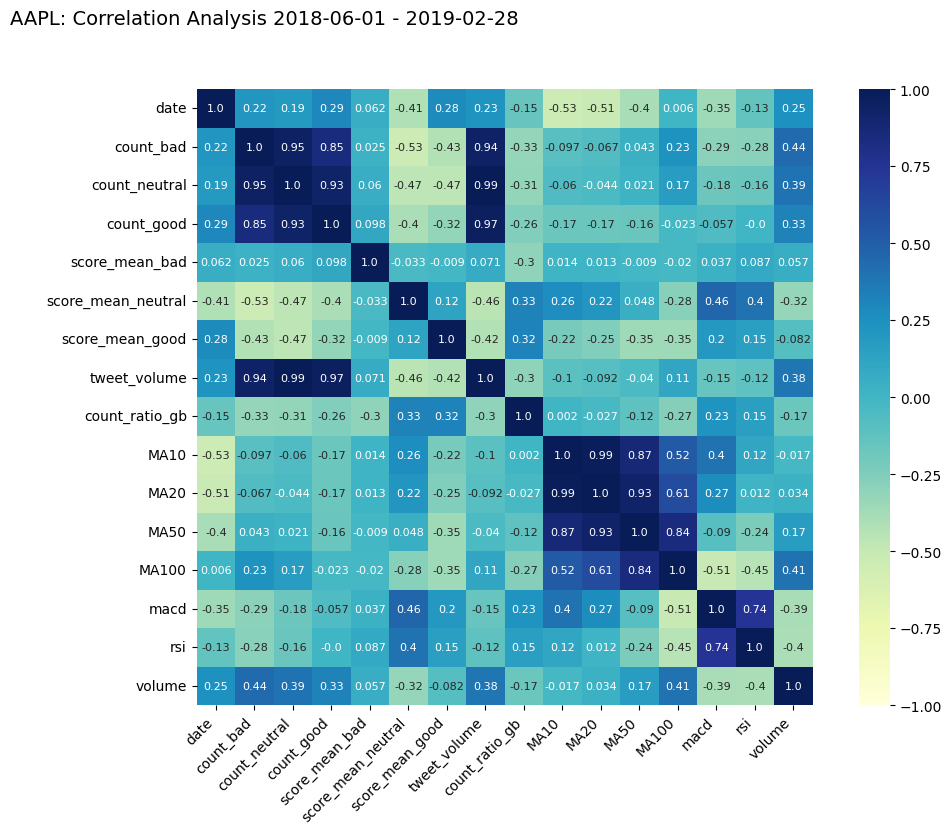

In [21]:
fig,ax = plt.subplots(figsize=(12, 8))
fig.suptitle(ticker + ": Correlation Analysis "+ start+ " - " + end,fontsize=14,horizontalalignment='right', verticalalignment='top')
ax=corr_plot(sp,tw)